In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('clean_data.csv')
del df['Unnamed: 0']
del df['opening_pgn']
del df['pgn']
del df['game_id']
df

,eco,opening,white_rating,black_rating,white_result,black_result,time_class,time_control,white_bracket,black_bracket
0,A21,English,1330,1384,checkmated,win,blitz,180,1300,1300
1,B01,Scandinavian,921,833,win,checkmated,blitz,300,900,800
2,A00,Uncommon Opening,1003,444,win,checkmated,bullet,60,1000,400
3,C23,Bishop's Opening,496,351,win,checkmated,blitz,180,400,300
4,A45,Queen's Pawn Game,1814,1761,win,resigned,rapid,600,1800,1700
...,...,...,...,...,...,...,...,...,...,...
9779,C20,King's Pawn Game,648,675,win,checkmated,rapid,600,600,600
9780,A10,English,1226,1197,win,timeout,bullet,60,1200,1100
9781,B10,Caro-Kann,887,864,resigned,win,rapid,600,800,800
9782,A01,Nimzovich-Larsen Attack,1799,1731,win,resigned,blitz,180,1700,1700


### Linear Regression
Basic framework of a linear regression model:
- find out the mean squared error for all the points
- find out the gradient descent (minimize the above function)
- plot the line based on the gradient descent function

In [3]:
# how do we determine when white has won the game
df = df.loc[(df['white_rating'] > 1000) & (df['black_rating'] > 1000)]
#plt.scatter(df['white_rating'], df['black_rating'])
df

,eco,opening,white_rating,black_rating,white_result,black_result,time_class,time_control,white_bracket,black_bracket
0,A21,English,1330,1384,checkmated,win,blitz,180,1300,1300
4,A45,Queen's Pawn Game,1814,1761,win,resigned,rapid,600,1800,1700
8,A22,English,1183,1151,win,timeout,blitz,300,1100,1100
9,B22,"Sicilian, Alapin",1533,1542,insufficient,insufficient,rapid,600,1500,1500
10,B01,Scandinavian,1048,1032,resigned,win,blitz,180,1000,1000
...,...,...,...,...,...,...,...,...,...,...
9770,C00,French Defense,1323,1320,timeout,win,bullet,60,1300,1300
9774,B06,Robatsch,1066,1049,win,resigned,blitz,180,1000,1000
9780,A10,English,1226,1197,win,timeout,bullet,60,1200,1100
9782,A01,Nimzovich-Larsen Attack,1799,1731,win,resigned,blitz,180,1700,1700


Let us now find out the mean squared error for all the points in the chosed dataset for all players with a rating above 2000. 

In [4]:
def mean_squared_error(m, c, df):
    error = 0
    for i in range(len(df)):
        x = df.iloc[i].white_rating
        y = df.iloc[i].black_rating
        error += (y-(m*x + c)) ** 2
    mse = error/float(len(df))
    print(mse)

We will have to normalize the data due to the large variation in values of x and y

Let us now minimize this function using gradient descent

In [5]:
def gradient_descent(m_now, c_now, df, L):
    m_grad = 0
    c_grad = 0
    n = len(df)
    for i in range(n):
        x = df.iloc[i].white_rating
        y = df.iloc[i].black_rating

        m_grad += -(2/n) * x * (y - (m_now * x + c_now))
        c_grad += -(2/n) * (y - (m_now * x + c_now))

        #print(m_grad, c_grad)

    m = m_now - m_grad * L
    c = c_now - c_grad * L
    return m,c

gradient_descent(0,0,df, 0.0001)

(411.2686352493848, 0.2808718854842327)

Testing it out

Optimized parameters: m = 1.0043344528048515 c = 0.0007525003223438023


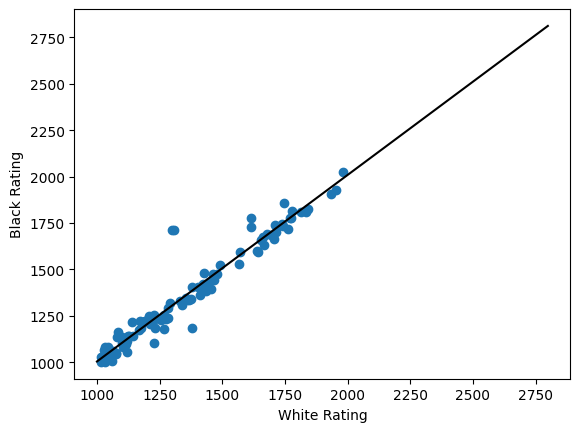

In [6]:
m = 0
c = 0
L = 0.0000001 # the important observation is that decreasing L has given positive and desired m and c results
# Learning rate is a parameter used in optimization to control the step size
epochs = 300 

tf = df

df = df.sample(n=100)

for i in range(epochs):
    m, c = gradient_descent(m, c, df, L)

print("Optimized parameters: m =", m, "c =", c)

plt.scatter(df['white_rating'], df['black_rating'])
plt.xlim = (min(df['white_rating']), max(df['white_rating']))
plt.ylim = (min(df['black_rating']), max(df['black_rating']))
plt.plot(list(range(1000, 2800)), [m * x + c for x in range(1000, 2800)], color = "black") # the problem lies here or in the gradient descent function so fix the issue there
plt.xlabel('White Rating')
plt.ylabel('Black Rating')
plt.show()

### Logistic Regression

#### What is logistic regression?
- fitting points to a line but in a kind of probabilistic way
- involves a kind of hypothesis testing that determines whether current event will occur or not

In [14]:
df.head()

,eco,opening,white_rating,black_rating,white_result,black_result,time_class,time_control,white_bracket,black_bracket
511,C20,King's Pawn Game,1282,1241,win,resigned,blitz,300,1200,1200
628,C45,Scotch Game,1233,1187,win,checkmated,rapid,600,1200,1100
7407,A00,Uncommon Opening,1045,1081,resigned,win,rapid,600,1000,1000
9714,B20,Sicilian,1126,1139,timeout,win,blitz,300,1100,1100
9178,D00,Queen's Pawn Game,1066,1061,checkmated,win,rapid,600,1000,1000


In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


m_now = 0  
c_now = 0  
learning_rate = 0.01  
num_iterations = 300

for iteration in range(num_iterations):
    m_grad = 0
    c_grad = 0
    n = len(df)
    
    for i in range(n):
        x = df.iloc[i].white_rating
        y = df.iloc[i].black_rating

        y_pred = sigmoid(m_now * x + c_now)
        print(y_pred, m_now, c_now)

        m_grad += -1/n * x * (y - y_pred)
        c_grad += -1/n * (y - y_pred)

    
    m_now -= m_grad * learning_rate
    c_now -= c_grad * learning_rate


0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
0.5 0 0
1.0 19242.24215000001 13.636800000000001
1.0 19242.24215000001 13.636800000000001
1.0 19242.24215000001 13.636800000000001
1.0 19242.24215000001 13.636800000000001
1.0 19242.24215000001 13.63680000000

Since the manual method does not work as expected, let us try it using scikit-learn

In [15]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

In [16]:
from sklearn.model_selection import GridSearchCV
parameter = {'penalty':['l1','l2','elasticnet'], 'C':[1,2,3,4,5,6,10,20,30,40,50], 'max_iter':[100,200,300]}

In [22]:
classifier_regressor = GridSearchCV(classifier, param_grid=parameter, scoring='accuracy')

### K means clustering

In [25]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [26]:
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


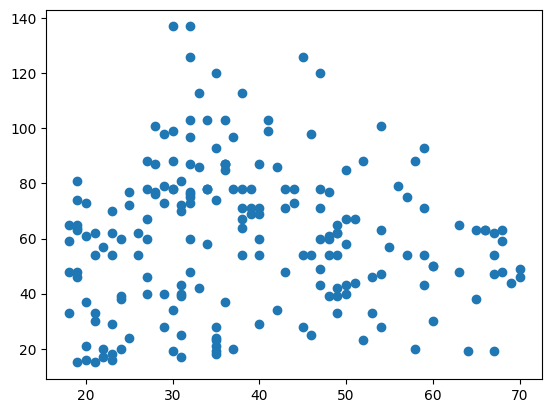

In [28]:
plt.scatter(df['Age'], df['Annual Income (k$)'])

In [32]:
km = KMeans(n_clusters=3)
km

KMeans(n_clusters=3)

In [33]:
y_predicted = km.fit_predict(df[['Age','Annual Income (k$)']])
y_predicted

c:\Users\sruja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [34]:
df['cluster'] = y_predicted
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19,15,39,2
1,2,Male,21,15,81,2
2,3,Female,20,16,6,2
3,4,Female,23,16,77,2
4,5,Female,31,17,40,2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


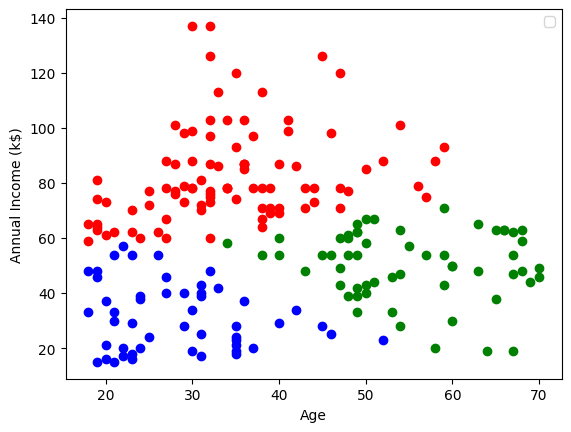

In [36]:
df1 = df[df.cluster == 0]
df2 = df[df.cluster == 1]
df3 = df[df.cluster == 2]

plt.scatter(df1.Age, df1["Annual Income (k$)"], color = 'green')
plt.scatter(df2.Age, df2["Annual Income (k$)"], color = 'red')
plt.scatter(df3.Age, df3["Annual Income (k$)"], color = 'blue')

plt.xlabel('Age')
plt.ylabel("Annual Income (k$)")
plt.legend()

In [44]:
scaler = MinMaxScaler()
scaler.fit(df[['Annual Income (k$)']])
df['Annual Income (k$)'] = scaler.transform(df['Annual Income (k$)'])
df



c:\Users\sruja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[ 15.  15.  16.  16.  17.  17.  18.  18.  19.  19.  19.  19.  20.  20.
  20.  20.  21.  21.  23.  23.  24.  24.  25.  25.  28.  28.  28.  28.
  29.  29.  30.  30.  33.  33.  33.  33.  34.  34.  37.  37.  38.  38.
  39.  39.  39.  39.  40.  40.  40.  40.  42.  42.  43.  43.  43.  43.
  44.  44.  46.  46.  46.  46.  47.  47.  48.  48.  48.  48.  48.  48.
  49.  49.  50.  50.  54.  54.  54.  54.  54.  54.  54.  54.  54.  54.
  54.  54.  57.  57.  58.  58.  59.  59.  60.  60.  60.  60.  60.  60.
  61.  61.  62.  62.  62.  62.  62.  62.  63.  63.  63.  63.  63.  63.
  64.  64.  65.  65.  65.  65.  67.  67.  67.  67.  69.  69.  70.  70.
  71.  71.  71.  71.  71.  71.  72.  72.  73.  73.  73.  73.  74.  74.
  75.  75.  76.  76.  77.  77.  77.  77.  78.  78.  78.  78.  78.  78.
  78.  78.  78.  78.  78.  78.  79.  79.  81.  81.  85.  85.  86.  86.
  87.  87.  87.  87.  87.  87.  88.  88.  88.  88.  93.  93.  97.  97.
  98.  98.  99.  99. 101. 101. 103. 103. 103. 103. 113. 113. 120. 120.
 126. 126. 137. 137.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [38]:
k_rng = range(1, 20)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df[["Age", "Annual Income (k$)"]])
    sse.append(km.inertia_)

sse

c:\Users\sruja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\sruja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\sruja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\sruja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

[176108.78000000003,
 87121.56591478697,
 59486.96143928036,
 39502.77850064538,
 31647.07578837987,
 25643.26532025946,
 21917.57159310879,
 18864.876029385057,
 15976.994655875525,
 13893.354160888059,
 12254.25175307784,
 11247.130090304432,
 10210.946268351532,
 9014.127112137947,
 8439.32038712921,
 7691.748122141016,
 7119.82551892552,
 6618.426516212546,
 6104.420182595183]

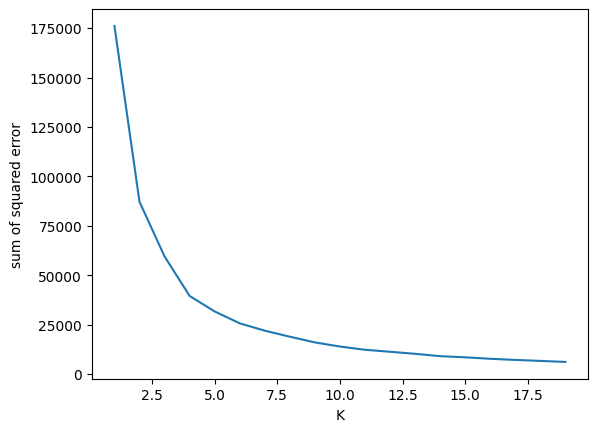

In [39]:
plt.xlabel('K')
plt.ylabel("sum of squared error")
plt.plot(k_rng, sse)